In [6]:
import pandas as pd
import re
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.max_colwidth', None)  # Show full column width
pd.set_option('display.expand_frame_repr', False)  # Prevent truncation
pd.set_option('display.float_format', '{:.10f}'.format)
def convert_play_value(value):
    if '万' in value:
        value = value.replace('万', '')
        return str(int(float(value) * 10000))
    return value

df = pd.read_csv('C:\\Users\\57016\\PycharmProjects\\All_about_social_mentality_online\\comments_community.csv')
print(df.shape)
df['play'] = df['play'].apply(convert_play_value)
df['count'] = df.groupby(['author', 'title', 'oid', 'play'])['author'].transform('size')
print(df)


(60386, 13)
                                                                 title                   oid   author     play        username sex location                                                                                                                                                                                                                                                                                 text  likes    time  Centrality  community  node_id  count
0                                                阿里的预赛考93有多难？清华博士：我做不到 1005894049.0000000000    漫士沉思录  1560000         clem就是我   男       北京  拥有这样的天赋可太难了，高中的时候我也是数学满分如喝水吃饭，还偶尔会是全年级唯一150/高分这种情况，竞赛也水了省二，高考数学也差点满分，一度觉得自己数学是很不错的。但是进大学还是被高数线代狠狠碾压，天天刷题只能勉强优秀，身边有同学天天打王者，8点的考试，考前通宵线玩到4点，第二天考满分。成为艺术品其实太奢求了，真正拥有天赋的人本就是极少数，甚至我们日常生活都碰不到，而能找到自己擅长的领域，到底需要多少运气和试错成本呢，这可能不是普通家庭和普通气运的人妄求能达到的。而在事实上意识到这一切后，我真心觉得能拥有平淡且有稍微一些意义的人生就很珍贵了。   2893  15天前发布           2          3       44    221
1                                             

(893, 14)


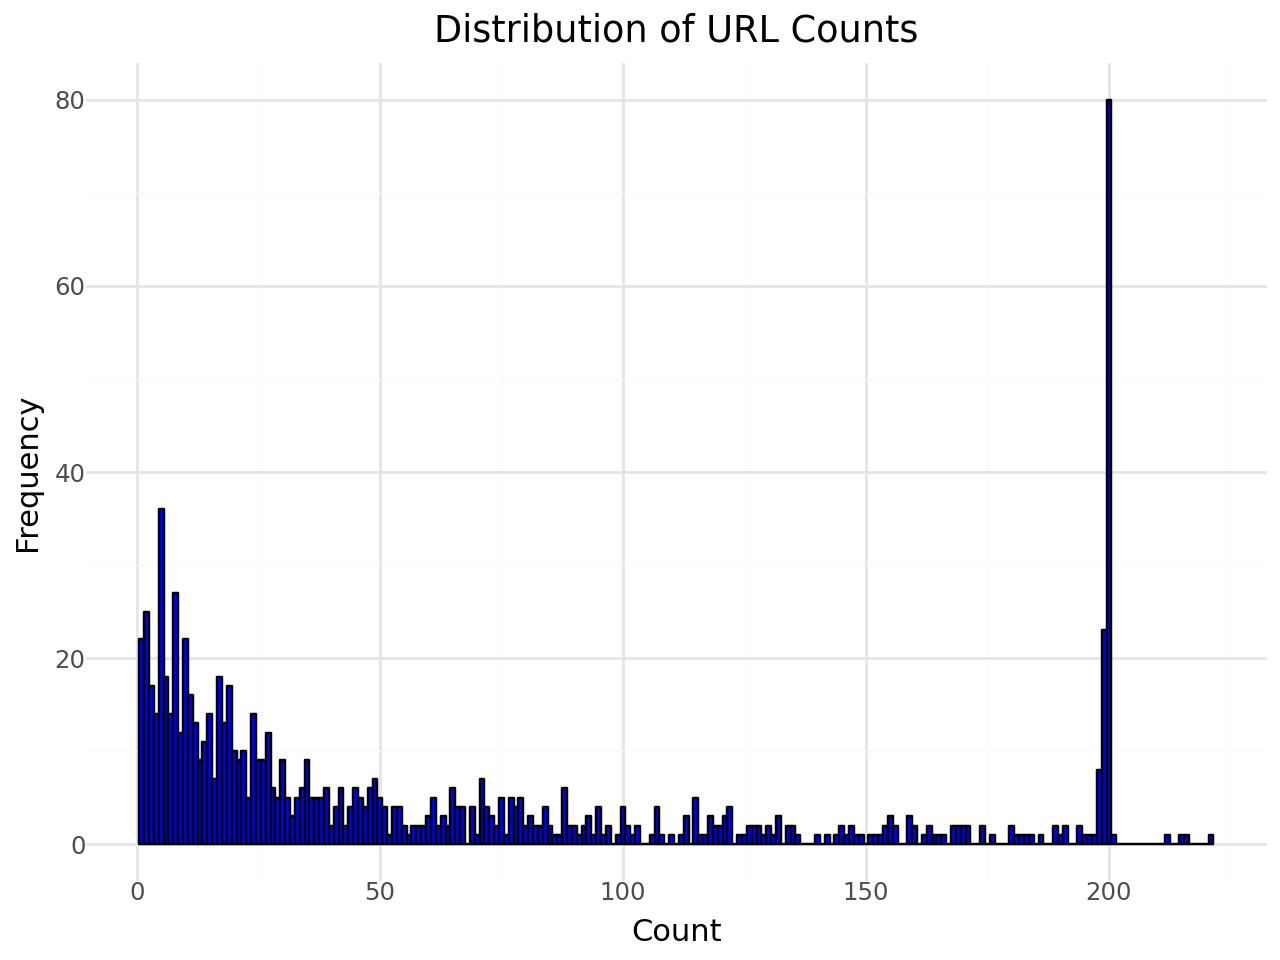

                    title                   oid author     play username sex location                                                                                                                                                                                                                              text  likes    time  Centrality  community  node_id  count
2   阿里的预赛考93有多难？清华博士：我做不到 1005894049.0000000000  漫士沉思录  1560000    开心的王王   男       重庆                                                                                    她在中专挺好的，要是在普高的话，浪费时间去学其他科目就是得不偿失。在中专既可以学习数学，又刚好遇到伯乐，还可以学习服装设计，这样数学的纯理性逻辑和手工设计的运用实践相结合，是非常好的。中考分流对于大部分普通人是好的，至于天才，他们会自己找到出路，就像夜空中的星星自会熠熠生辉，不必担心   1572  15天前发布           2          3       44    221
3   阿里的预赛考93有多难？清华博士：我做不到 1005894049.0000000000  漫士沉思录  1560000   阿星吧123  保密       北京                                                                                                                                                                                       

In [7]:
# descriptive
from plotnine import ggplot, aes, geom_histogram, geom_boxplot, theme_minimal, labs
df_unique = df.drop_duplicates(subset=['title'])
print(df_unique.shape)
descriptive_stats = df_unique['count'].describe()
histogram = (ggplot(df_unique, aes(x='count'))
             + geom_histogram(binwidth=1, fill="blue", color="black")
             + theme_minimal()
             + labs(title='Distribution of URL Counts', x='Count', y='Frequency'))
ggplot.show(histogram)

df_peek = df.sort_values(by='count', ascending=False)
print(df_peek.head())
print(descriptive_stats)


In [9]:
# bag of words approach
df['text_bag'] = df.groupby(['author', 'title', 'oid', 'play'])['text'].transform(lambda x: ' '.join(x))
df_trimbag = df.drop_duplicates(subset=['author', 'title', 'oid', 'play'])
df_trimbag.to_csv('dr_trimbag.csv', index=False)

In [12]:
import jieba
import numpy as np

df = pd.read_csv('dr_trimbag.csv')
df['doc_index'] = range(1, len(df) + 1)

def remove_non_chinese(text):
    return re.sub(r'[^\u4e00-\u9fff]+', '', text)

# Apply the function to remove non-Chinese characters
df['text_bag'] = df['text_bag'].apply(remove_non_chinese)

def tokenize(text):
    return ' '.join(jieba.cut(text))

df['text_bag'] = df['text_bag'].apply(tokenize)
#print(df.head())
df.to_csv('community_tokenized.csv')

In [11]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import numpy as np
from plotnine import ggplot, aes, geom_point, labs, theme_minimal

vectorizer = CountVectorizer()
X = vectorizer.fit_transform(df['text_bag'])

n_topics = 1  # Number of latent topics (similar to the dimensionality in Wordfish)
lda = LatentDirichletAllocation(n_components=n_topics, random_state=0)
lda_scores = lda.fit_transform(X).flatten()

# Add the LDA scores back to the DataFrame
df['lda_score'] = lda_scores


df_peek = df.sort_values(by='lda_score', ascending=False)
df_peek.to_csv('df_peek.csv')

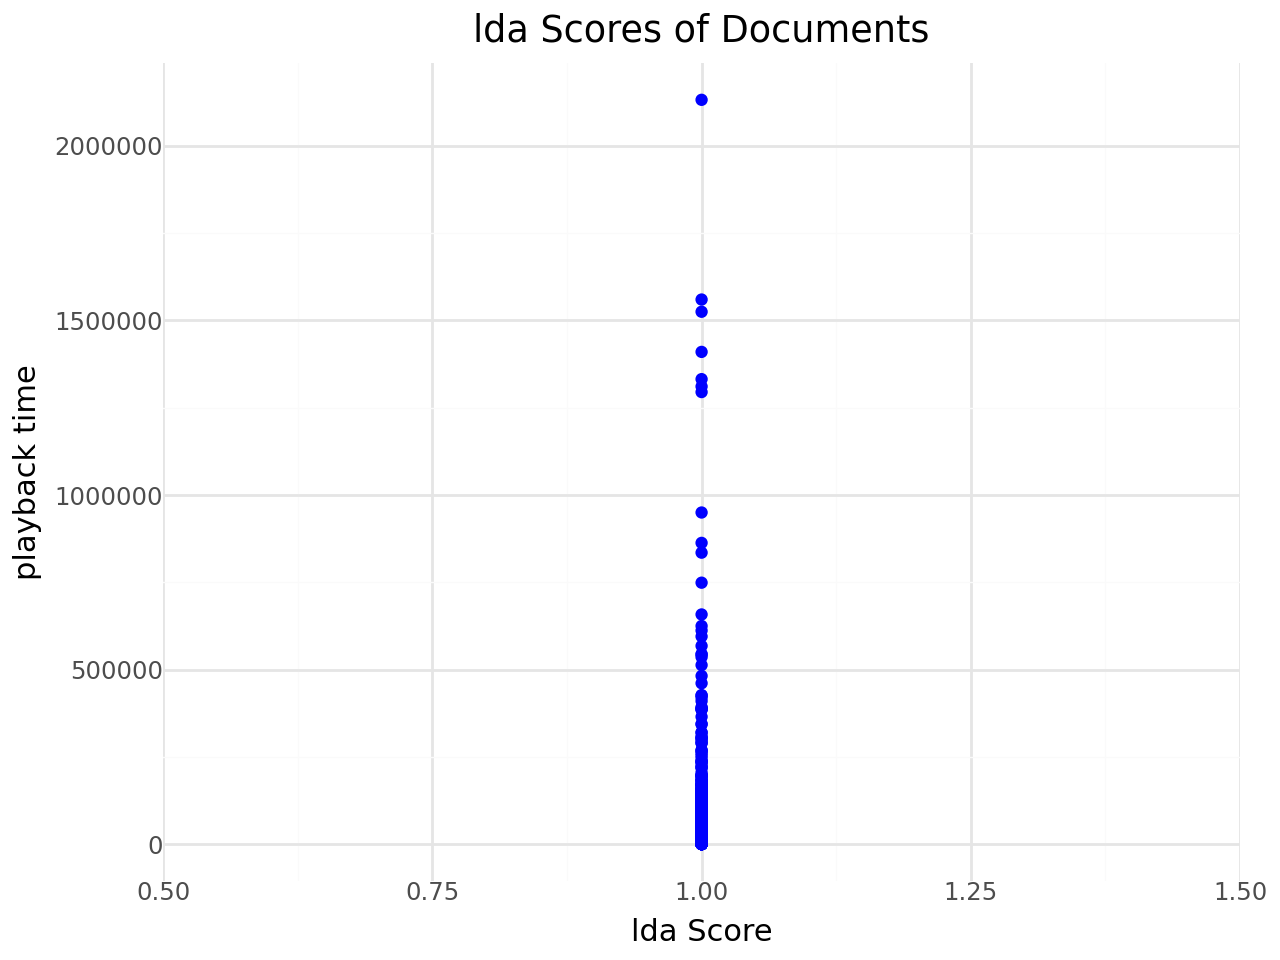

In [59]:
from plotnine import ggplot, aes, geom_point, labs, theme_minimal

# Plotting the Wordfish scores
plot = (ggplot(df, aes(x='lda_score', y='play'))
        + geom_point(color='blue')
        + labs(title='lda Scores of Documents', x='lda Score', y='playback time')
        + theme_minimal())

ggplot.show(plot)


In [52]:
# Print documents with highest and lowest scores
print("Documents with highest scores:")
print(df.nlargest(15, 'wordfish_score')[['title']])

print("\nDocuments with lowest scores:")
print(df.nsmallest(15, 'wordfish_score')[['title']])


Documents with highest scores:
                                                                   title
74                                                   姜萍回应质疑，展示其数学笔记黑子们说话
345                             姜萍的同学说决赛完事后，姜萍是带着笑容离开决赛考场，天赋，兴趣和努力是战无不胜的
723                                      韦东奕也没有这样神！江苏中专女生姜萍自学数学，闯入全球第12名
43                                              【结合目前所有证据】一个视频让你真正看透姜萍事件
285                                                        那些质疑姜萍作弊的打脸了吧
762                                                            《姜萍受害论》分析
851                                                            人人都可是“姜萍”
290                                                   真相了！姜萍老师王闰秋紧张的不得了！
348                                                   "姜萍独立完成决赛，微笑走出考场？"
464                                            Young and Beautiful（阿姨群像）
112                                                     有没有数学好的女孩子为姜萍发生？
104                                                                六爻测姜萍
532                 